# Úkol č. 2 - Nesupervizované shlukování / segmentace

## Zdroje dat

Pomocí algoritmu shlukování udělejte segmentaci na jednom z následujících datasetů:
- https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python
- https://www.kaggle.com/arjunbhasin2013/ccdata
- https://www.kaggle.com/flyingwombat/us-news-and-world-reports-college-data

nebo jeden z Vašich datasetů. Pokud vidíte nějaký dataset, který má v názvu třeba: 'segmentation', 'basket', 'recommender', pravděpodobně je vhodný na klastrování. Je to jedno, co tam bude za data, hlavně aby Vás to bavilo. 


## Pokyny k vypracování

Proveďte analýzu vytvořených shluků pomocí metody/metod:
- K-Means (must have!)
- sihouette
- hdbscan
- chameleon
- atd.. 

(více na: https://pypi.org/project/clustviz)

Doporučuji počkat na přednášku o redukci dimenzionality, pomůže Vám s vizualizací.

## Poznámky k odevzdání

- Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body
- Deadline pro odevzdání je 15/5/2023 o půlnoci, odeslat na mail tichyon2@fit.cvut.cz

# Řešení

In [48]:
import warnings
import time
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
np.random.seed(int(time.time())) 

import matplotlib.pyplot as plt
import matplotlib
import scipy
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)

In [49]:
data = pd.read_csv('hw2/Mall_Customers.csv')
# display num of rows and columns
print(data.shape)

(200, 5)


## Data preprocessing
V datech jsou i neceločíselná data - např. stringy "Male"/"Female". Vše převedeme na číselné hodnoty. 

In [50]:
display(data.head()) # we see there are some object data types - we want to convert them
# change object types to categories, so the string values are converted to descrete numeric
string_cols = data.select_dtypes(['object']).columns # non numeric series
print("columns with type object")
print(string_cols)
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes) # on this line we convert
display(data.dtypes) # now we have only numeric variables
display(data.head())
X = data.values

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

columns with type object
Index(['Gender'], dtype='object')


CustomerID                int64
Gender                     int8
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
dtype: object

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1       1   19                  15                      39
1           2       1   21                  15                      81
2           3       0   20                  16                       6
3           4       0   23                  16                      77
4           5       0   31                  17                      40

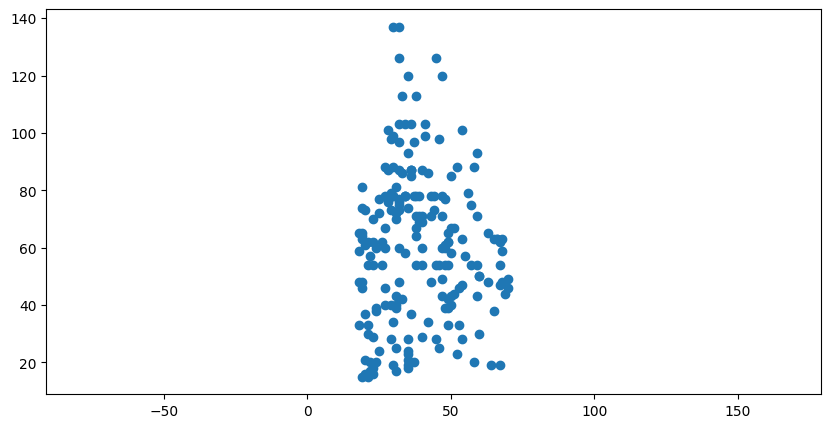

In [51]:
# pro 2D grafy používám v celém notebooku tyto 2 sloupce
col1 = 2 # age
col2 = 3 # income
plt.figure(figsize=(10, 5))
plt.scatter(X[:,col1], X[:,col2]) # age vs annual income
plt.axis('equal')
plt.show()

### Co je to shlukování?
- shlukování (clustering) obecně je hledání nějaké struktury v neznámých datech (obecně hledání míst, kde se mnoho datových bodů koncentruje na malém prostoru, ideálně v menším subsetu dimenzí)
- jde o jeden z problémů "učení bez učitele" (unsupervized learning), který je charakteristický tím, že nemáme danou proměnnou, kterou se snažíme naučit predikovat a tedy ani žádné měřítko, jak ohodnotit kvalitu výsledného modelu 
## Hierarchické - aglomerativní shlukování
- v této metodě se na začátku každý bod inicializuje jako jeden samostatným shluk
- iterativně se pak:
1) spočítají vzdálenosti každých dvou shluků (více metod jak to provést)
2) dva nejbližší shluky se spojí do jednoho nového
proces konverguje k jedinému shluku, můžeme zastavit dřív podle limitu a) počet shluků b) vzdálnost pro spojení dvou shluků

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage

# matice propojení - každý řádek je spojení dvou shluků do jednoho
# využití euklidovské metriky pro měření vzdálenosti dvou bodů, single linkage pro způsob vyhodnocení vzdálenosti dvou shluků
Z = linkage(X, method="single", metric="euclidean")
# rozměry výstupu
print(Z.shape)

(199, 4)


In [53]:
# Podívejme se na prvních X řádků matice
# každá řádka obsahuhe: 1) index 1. shluku 2) index 2. shluku 3) vzdálenost spojovaných shluků 4) počet datových bodů v novém shluku
print(Z[:10,:])

[[ 48.       49.        2.23607   2.     ]
 [129.      131.        2.23607   2.     ]
 [114.      115.        2.44949   2.     ]
 [  3.        5.        2.64575   2.     ]
 [113.      202.        2.82843   3.     ]
 [ 65.       68.        3.16228   2.     ]
 [ 83.       85.        3.60555   2.     ]
 [ 13.       15.        3.60555   2.     ]
 [117.      119.        3.60555   2.     ]
 [156.      158.        3.60555   2.     ]]


### Dendogram
Spojování menších shluků do větších se dá zaznamenat dendogramem.
Na Xové ose jsou samotné body, které jsou v začátku procesu samostatnými shluky.
Na Yové ose je vzdálenost. Podle toho lze zjistit kdy se dva dané shluky spojily, jak daleko od sebe byly.

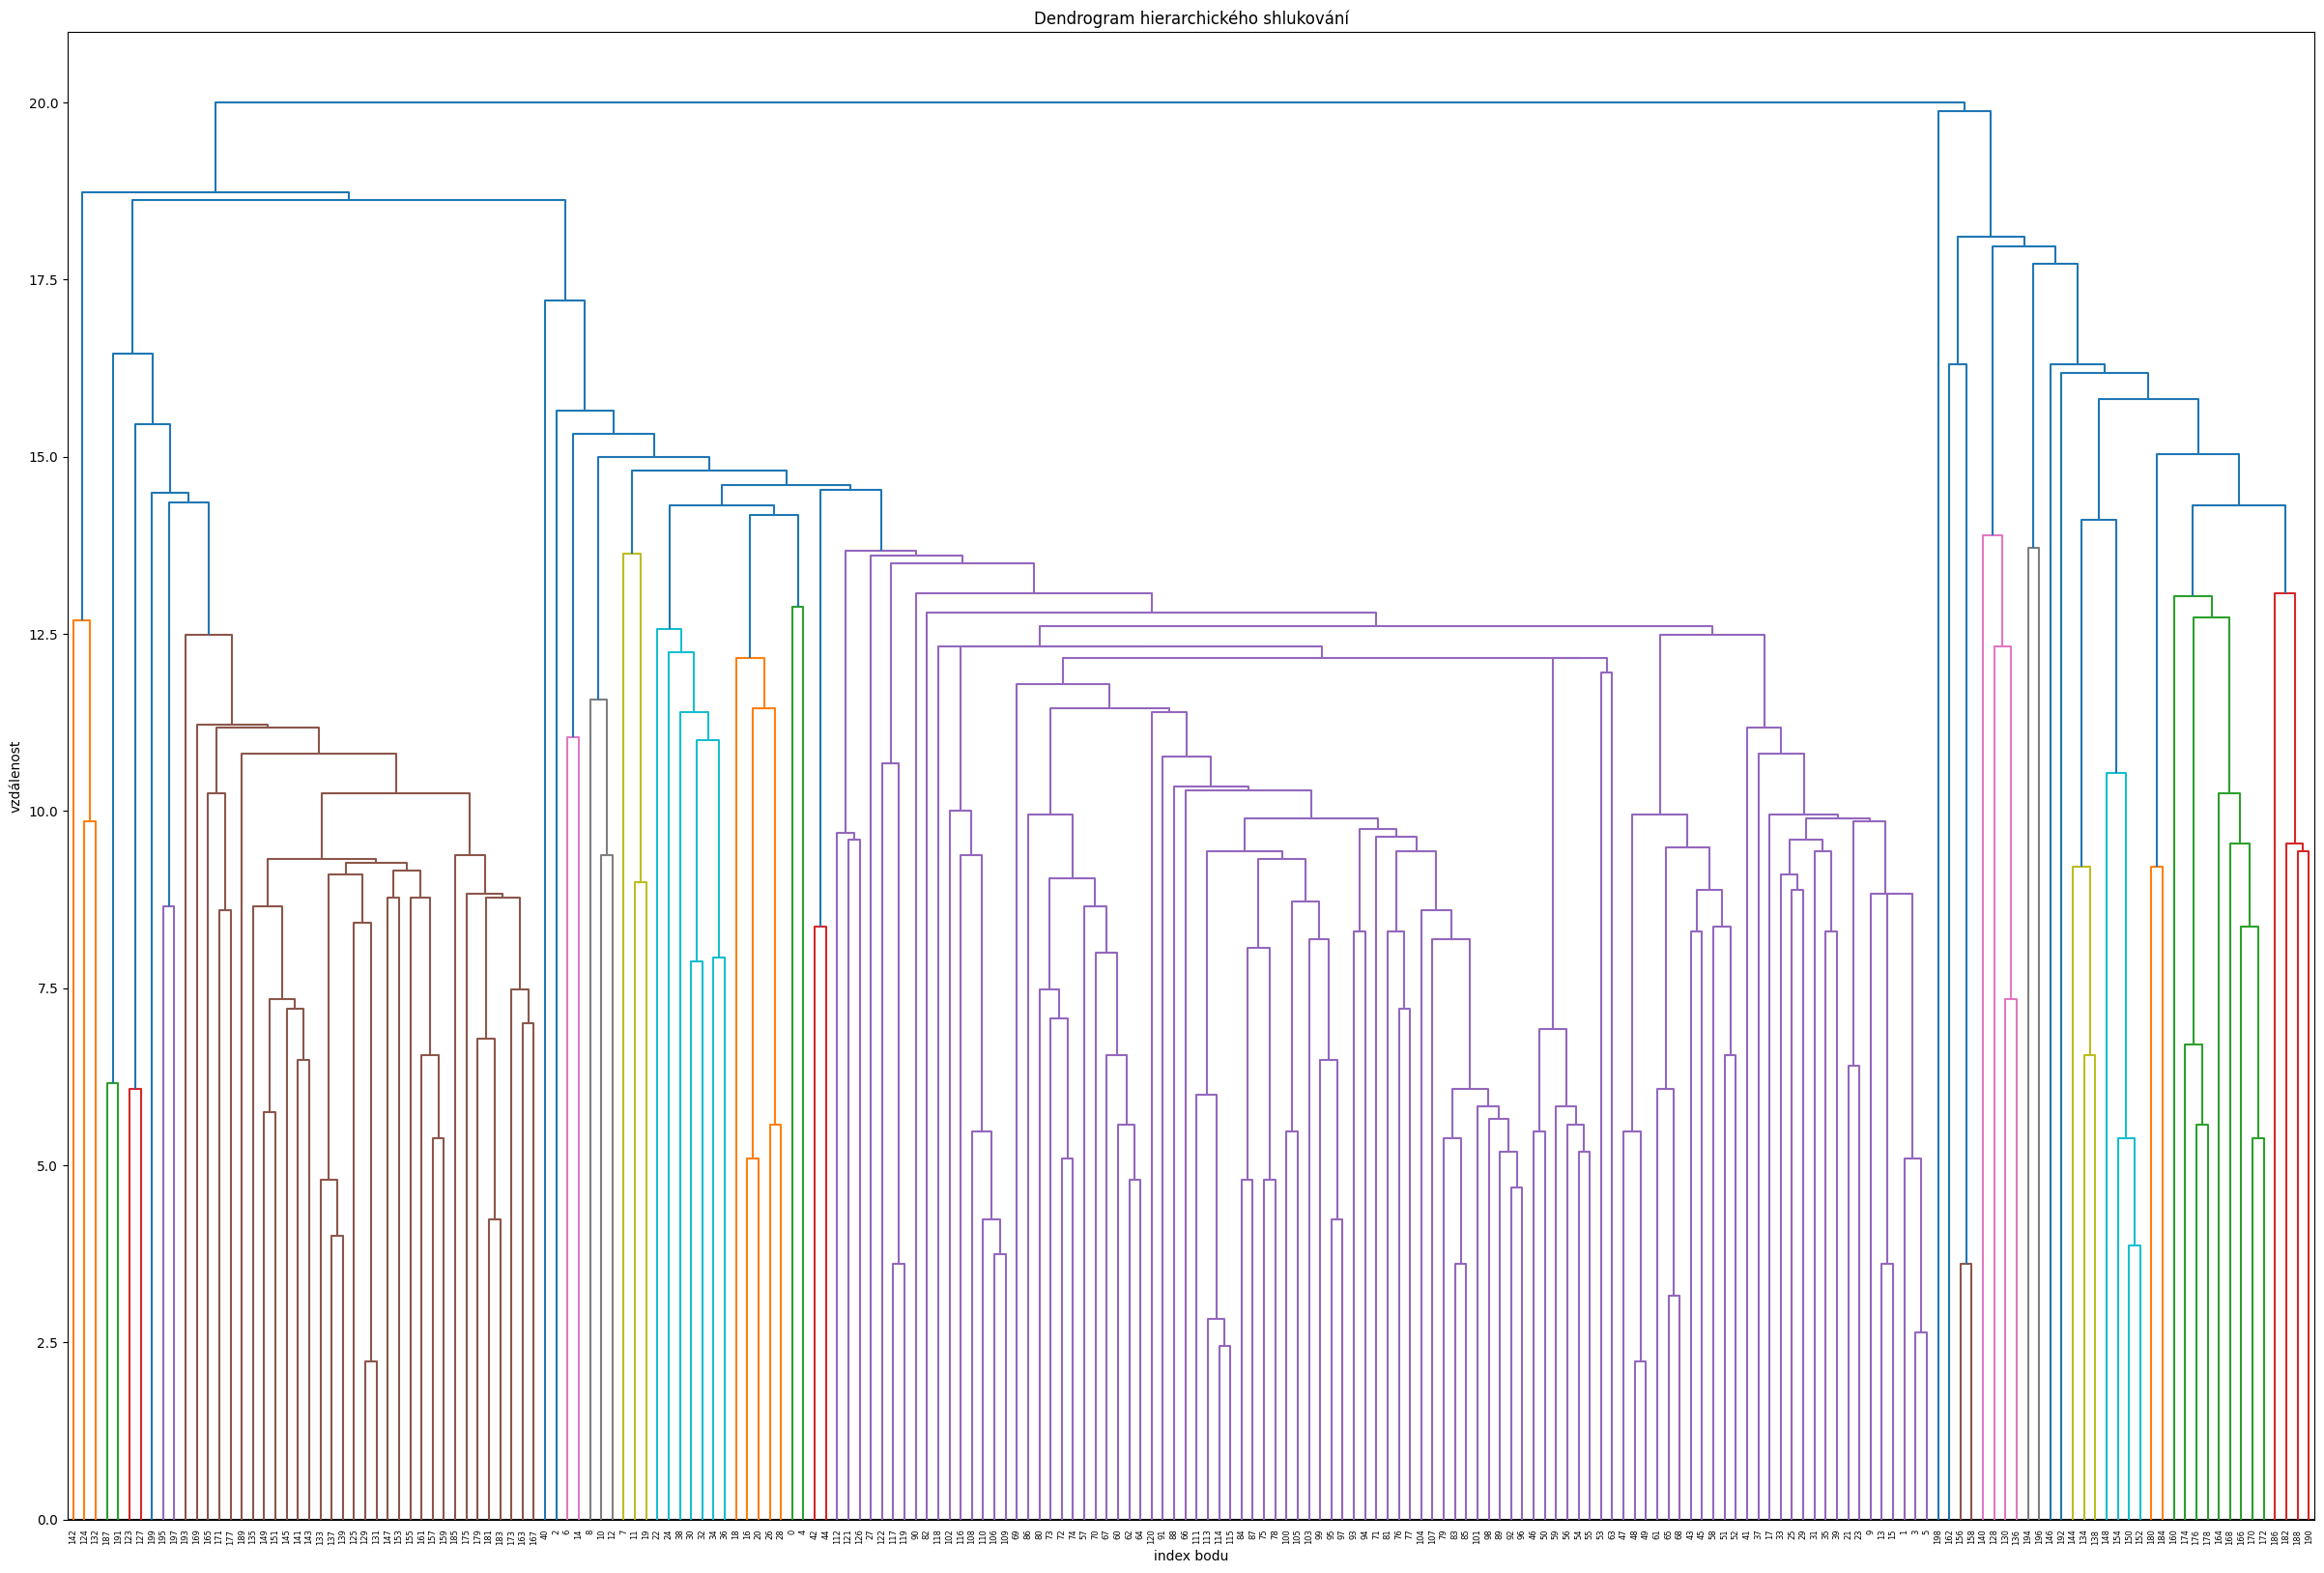

In [54]:
def printDendo(linkage_matrix, max_d = 0):
    plt.figure(figsize=(30, 20))
    plt.title("Dendrogram hierarchického shlukování")
    plt.xlabel("index bodu")
    plt.ylabel("vzdálenost")
    plt.axhline(y=max_d, c="k")

    dendrogram(
        linkage_matrix,
        leaf_rotation=90.,  # otočení popisů x-ové osy
        leaf_font_size=6.,  # velikost fontu popisů x-ové osy
    )

    plt.show()
printDendo(Z)

[ 6  6  7  6  6  6  5  6  6  6  6  6  6  6  5  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  8  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  3  1  4  6  3 11  4 11  4  1  4 13  4 11  4 13  4 11  4  1  4
 13  4 17  4 13  4 13  4 13  4 13  4  9  4  9  4 15  4 10  4 15  4 15  4
 15  4 15  4 15  4 15  4 15  4 15  4 14  4 15  4 14  4 15  2 15  4 15  2
 16  4 12  4 12  4 18  4]


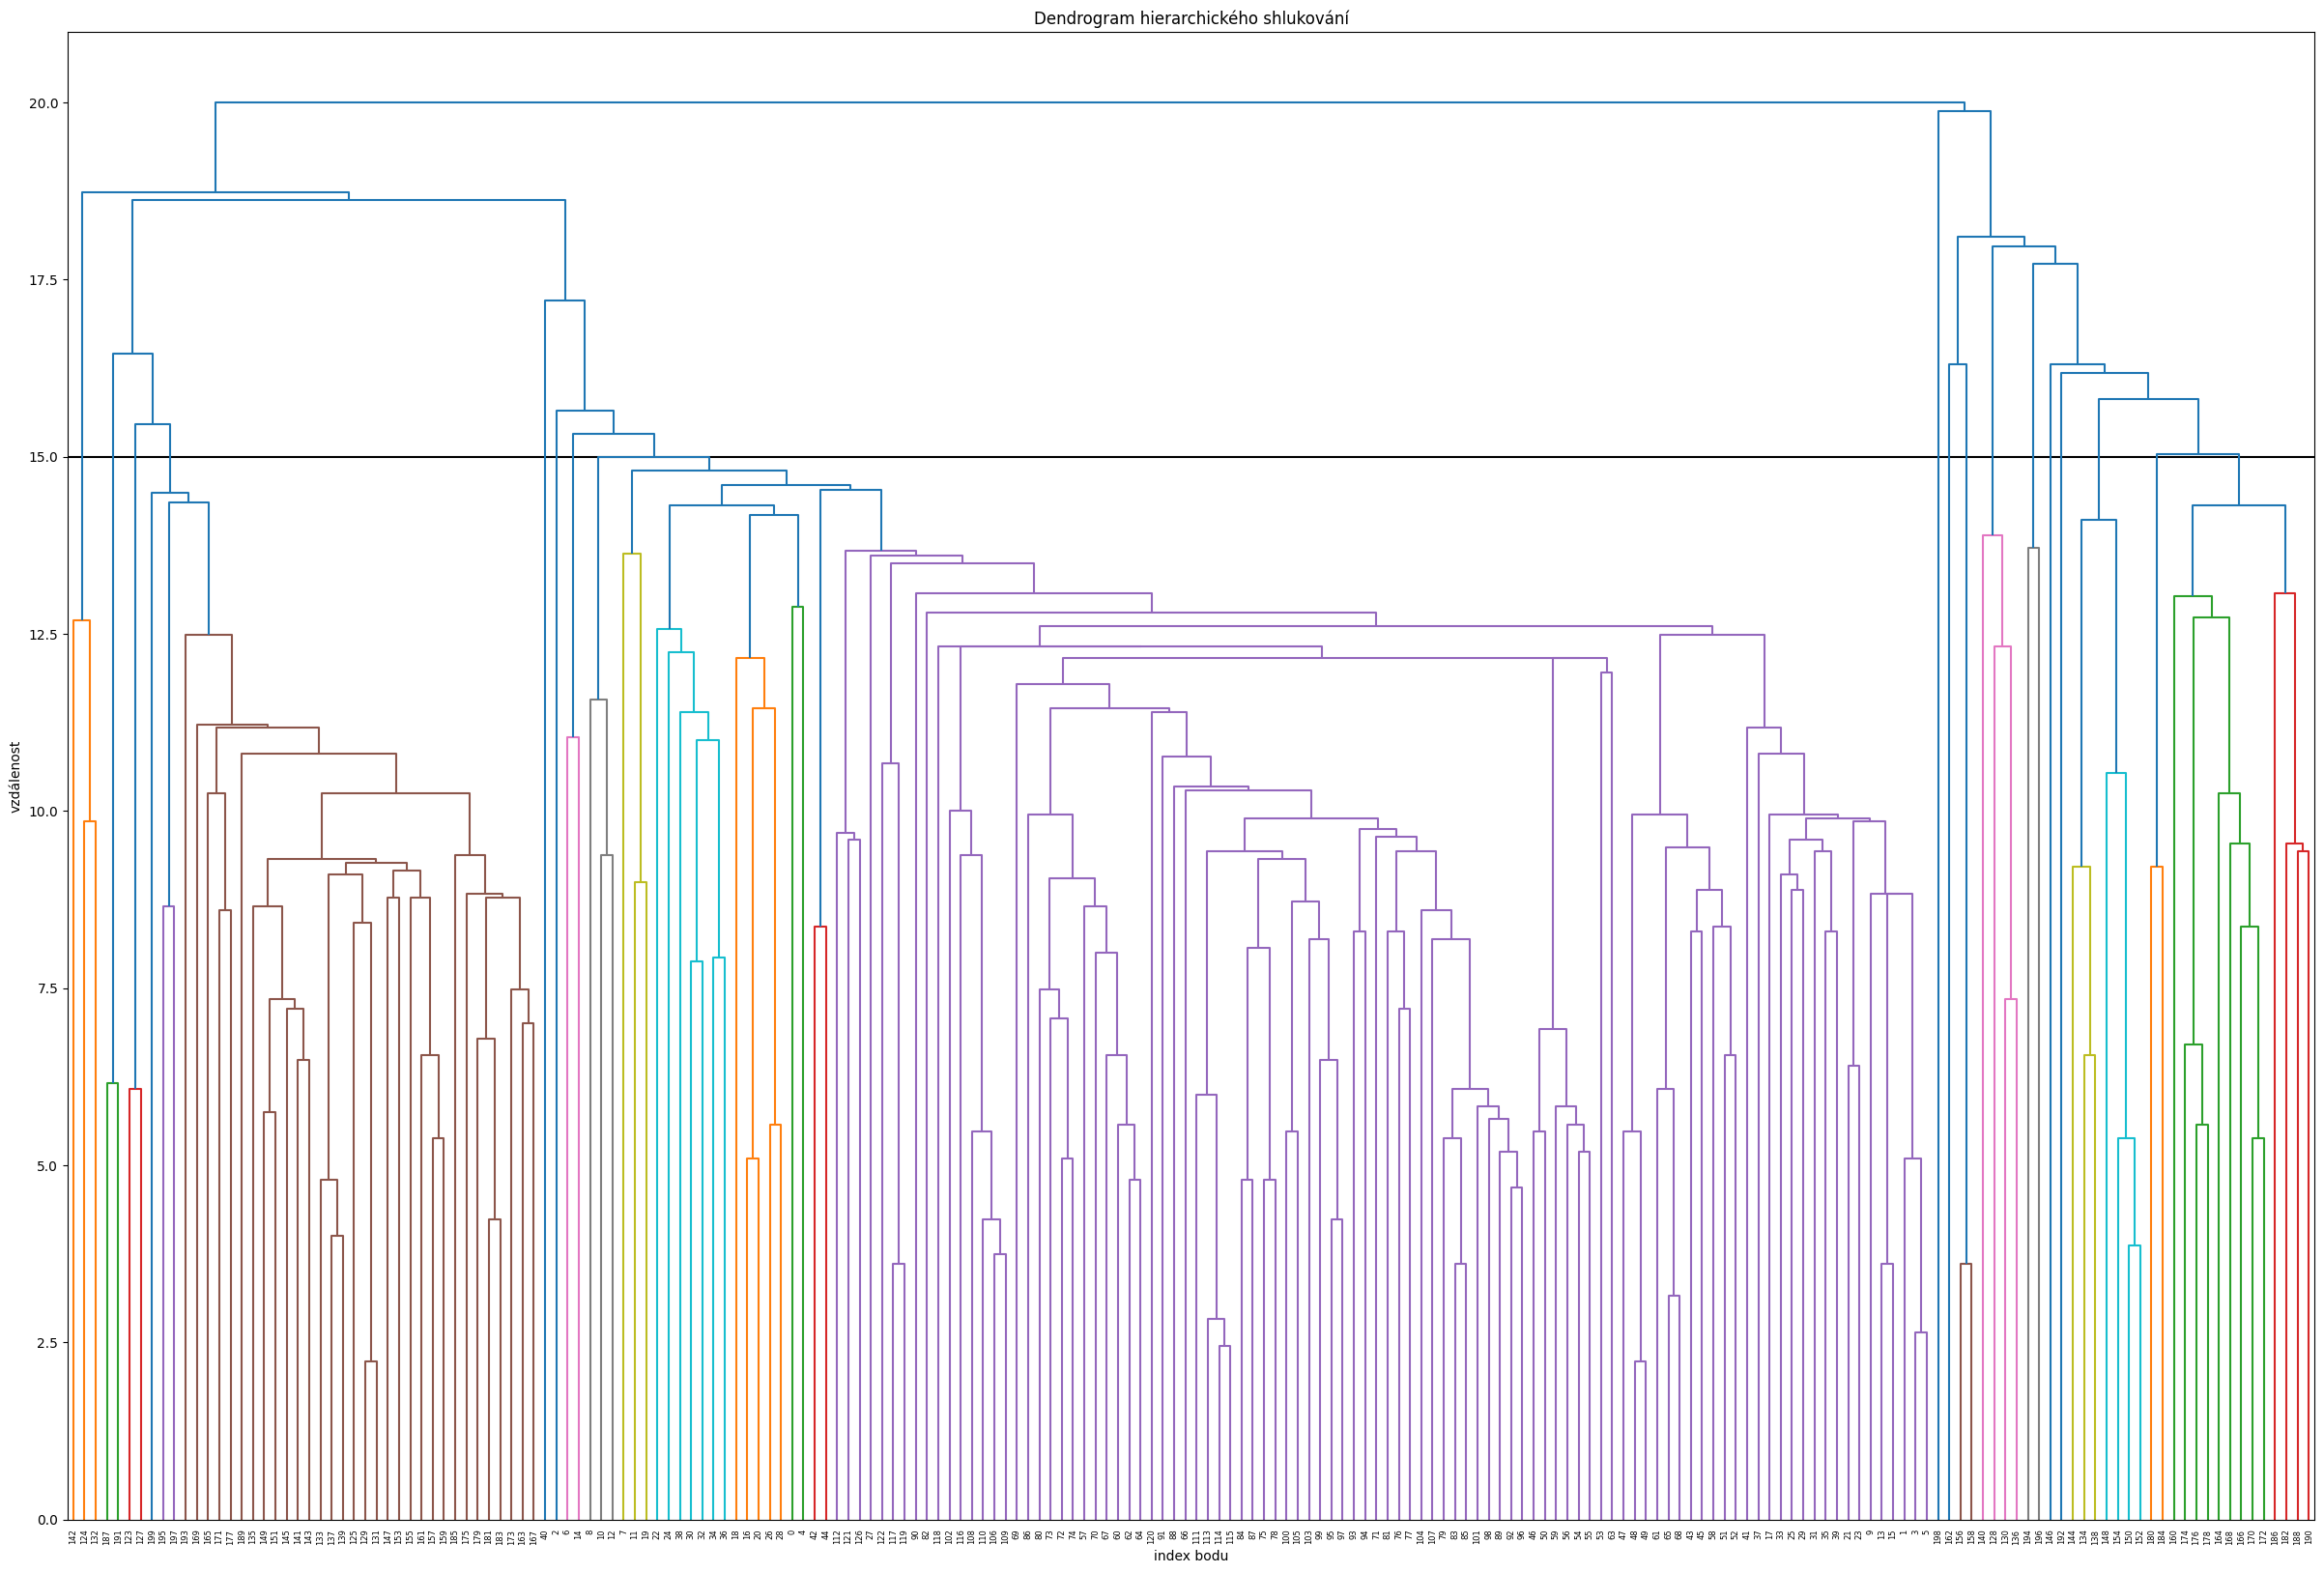

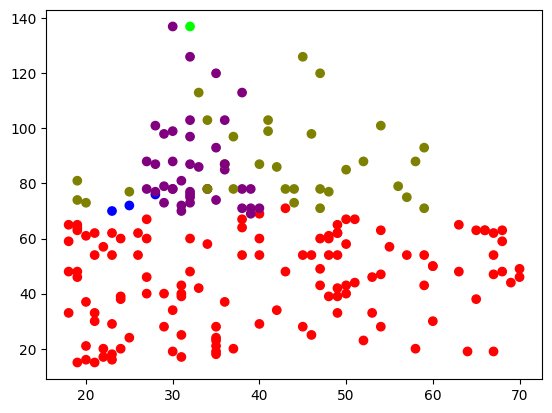

In [55]:
from scipy.cluster.hierarchy import fcluster

def printScatter(matrix, k = 1):
    k_clusters = fcluster(matrix, k, criterion="maxclust")
    plt.scatter(X[:,col1], X[:,col2], c=k_clusters, cmap="brg")
    plt.show()

## nastavení maximální vzdálenosti
max_d = 15 
## nastavení počtu shluků ve scatteru
k = 5

clusters = fcluster(Z, max_d, criterion="distance")

print(clusters)  # výpis shlukování, pro každý bod máme přiřazené číslo shluku do kterého patří
printDendo(Z, max_d)
printScatter(Z, k)

## K-Means
K means inicializuje na začátku procesu a) předem daný počet středů (budoucích shluků) b) a to na náhodné či nějak určené pozice (k-means++).
Poté iterativně:
- každý bod přiřadí k nejbližšímu středu -> tím vzniknou shluky
- pro každý shluk přepočte jeho skutečný střed.
- Kvalitu roztřídění hodnotíme nějakou hodnotící funkcí, s počtem iterací by měla hodnota výstupu klesat (=být optimálnější).

Počet středů 'k' je daný při inicializaci a v průběhu se nemění. "Ideální" hodnotu k hledáme pomocí "lokte", jde o hodnotu, kde hodnotící funkce z k+1 do k klesne nejvíce. 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 33.5       0.40909  38.24242  31.63636  50.16667]
 [168.48438   0.46875  36.42188  89.9375   51.51562]
 [101.51429   0.44286  41.64286  60.97143  49.02857]]


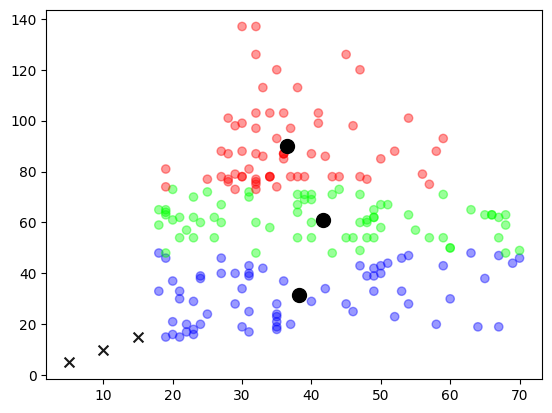

In [56]:
from sklearn.cluster import KMeans

# ukázka kmeans, se třemi středy 
def kmeans_fc(k, centers):
    # ukázka k-means pro 3 shluky s manuálně určenými středy
    # shlukování
    kmeans = KMeans(n_clusters = k, random_state = 1, init = initial_centers, n_init = 1).fit(X)

    # výsledné shluky
    print(kmeans.labels_)
    # a jejich středy
    print(kmeans.cluster_centers_)

    # Vizualizace
    plt.scatter(X[:,col1], X[:,col2], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
    plt.scatter(initial_centers[:,col1], initial_centers[:,col2], c = 'black', s=50, alpha = 0.9, marker = 'x') # initial centers
    plt.scatter(kmeans.cluster_centers_[:,col1], kmeans.cluster_centers_[:,col2], c = 'black', s=100) # final centers
    plt.show()

initial_centers = np.array([[10,10,10,10,10],[5,5,5,5,5],[15,15,15,15,15]])
kmeans_fc(3, initial_centers)

Nyní zkusíme najít optimální hodnotu k pomocí "lokte" či "bodu zlomu" a zkusíme tuto hodnotu použít.

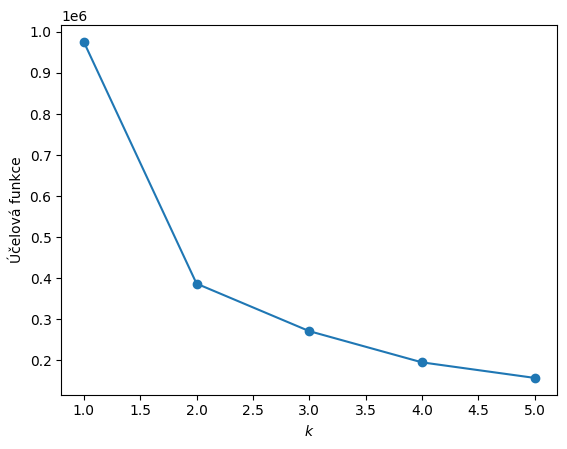

In [57]:
ix = np.zeros(5)
iy = np.zeros(5)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(X)
    iy[k] = kmeans.inertia_ # Sum of squared distances of samples to their closest cluster center
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 50.        0.40404  39.94949  39.34343  49.93939]
 [150.        0.47525  37.77228  81.35644  50.45545]]


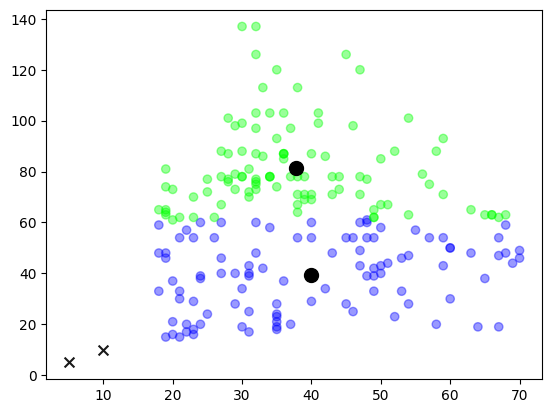

In [58]:
# podle grafu klesne účelová funkce nejvíce když jde do hodnoty 2 - proto ji dosadíme jako k, počet středů
initial_centers = np.array([[10,10,10,10,10],[5,5,5,5,5]])
kmeans_fc(2, initial_centers)

## DBSCAN

array([-1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  1,  0,
        1,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
        0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
        1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
        0,  1,  0,  1,  0,  1,  0,  1,  0, -1,  0, -1,  0], dtype=int64)

DBSCAN(eps=20)

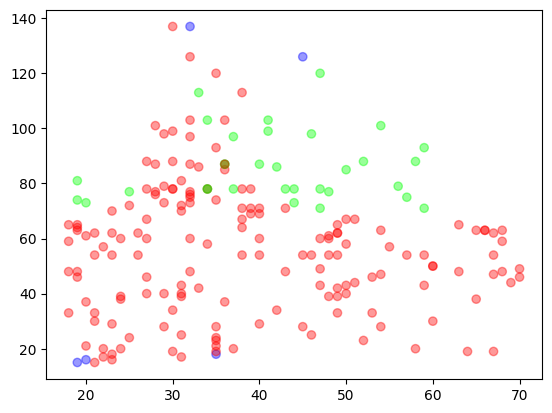

In [76]:
from sklearn.cluster import DBSCAN
import numpy as np
clustering = DBSCAN(eps=20, min_samples=5).fit(X)
display(clustering.labels_)
display(clustering)

# Vizualizace
plt.scatter(X[:,col1], X[:,col2], c=clustering.labels_, cmap='brg', alpha=0.4) # plot clustered points
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e90e9d6e-b1c2-41b4-8177-e94120d467e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>